In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import os
import pandas as pd

#### read ATMS data

In [13]:
y = xarray.open_dataset(os.path.expanduser('~/Projects/git/aws/Validation/TB_ATMS_m60_p60.nc'))
TB0 = y.TB
nchannels = y.channels.size
channels_id = y.channels.values
TB0

<xarray.DataArray 'TB' (channels: 7, sky: 2, cases: 125460)>
[1756440 values with dtype=float64]
Coordinates:
  * channels  (channels) object 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22'
  * sky       (sky) object 'clearsky' 'allsky'
  * cases     (cases) int64 0 1 2 3 4 5 ... 125455 125456 125457 125458 125459

#### add gaussian noise according to the NEDT of ATMS

In [3]:
def gaussian_noise(TB0, nchannels):
    nedt = [0.5, 0.6, 0.8, 0.8, 0.8, 0.8, 0.9]
    size_TB = TB0.shape[2]
    TB = TB0.copy()
    for ic in range(2):
        noise = np.array([np.random.normal(0, nedt[i], size_TB) for i in range(nchannels)])
        TB[:, ic, :] = TB0[:, ic, :] + noise
    return TB

In [4]:
TB = gaussian_noise(TB0, nchannels)

#### Read ATMS data, already subset using another function

In [5]:
fileName_atms = '/home/inderpreet/ATMS/brightness_temp_m60_p60.h5'
DF = pd.read_hdf(fileName_atms, 'DF')


In [6]:
##### divide ATMS into day/night

In [7]:
is_day = DF['sza'] <= 90.0
is_night = DF['sza'] > 90.0
DF_day = DF[is_day]
DF_night = DF[is_night]

#### calculate distribution of the ATMS observations

In [8]:
def hist_atms(DF, bins, vza_lims):
    DF_vza = DF[(DF['vza'] <= vza_lims[1]) & (DF['vza'] >= vza_lims[0])]
    hist0 = np.histogram(DF_vza['BT16'], bins, density = True)
    hist1 = np.histogram(DF_vza['BT17'], bins, density = True)
    hist2 = np.histogram(DF_vza['BT18'], bins, density = True)
    hist3 = np.histogram(DF_vza['BT19'], bins, density = True)
    hist4 = np.histogram(DF_vza['BT20'], bins, density = True)   
    hist5 = np.histogram(DF_vza['BT21'], bins, density = True)
    hist6 = np.histogram(DF_vza['BT22'], bins, density = True)

    hist_atms = (hist0[0], hist1[0], hist2[0], hist3[0], hist4[0], hist5[0], hist6[0])
    return hist_atms

In [9]:
bins =np.linspace(200, 300, 201)
vza_lims = (0, 1.5)
#vza_lims = (44, 46)

In [10]:
hist_atms_day = hist_atms(DF_day, bins, vza_lims)
hist_atms_night = hist_atms(DF_night, bins, vza_lims)

#### Calculate distribution of the ARTS simulations

In [11]:
hist_arts_cs      = []
hist_arts_as      = []
hist_arts_as_thin = []

bins = np.linspace(200, 300, 201)

ics = 0

ias = 1

cs_reject = 0.5

for c in range(nchannels):
    ireje = (abs(TB0[c, ias, :] - TB0[c, ics, :]) < 0.2) & (np.random.rand(TB.shape[2])< cs_reject)

    H = np.histogram(TB[c, ics,  :], bins, density = True)
    hist_arts_cs.append(H[0])   

    
    H_subset = np.histogram(TB[c, ias, :][~ireje], bins, density = True)
    H = np.histogram(TB[c, ias,  :], bins, density = True)
    hist_arts_as.append(H[0])   
    hist_arts_as_thin.append(H_subset[0])   


#### Plot the distributions for  7 ATMS channels

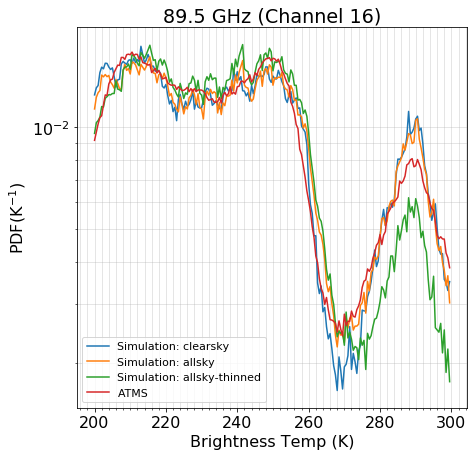

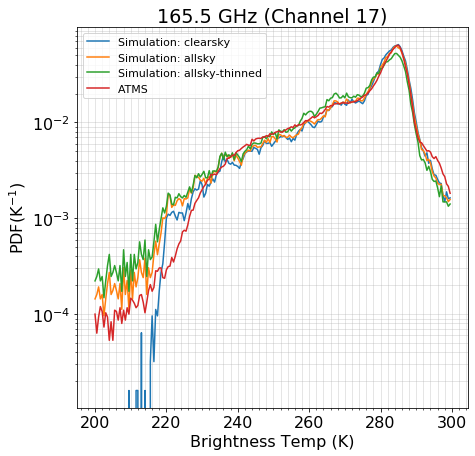

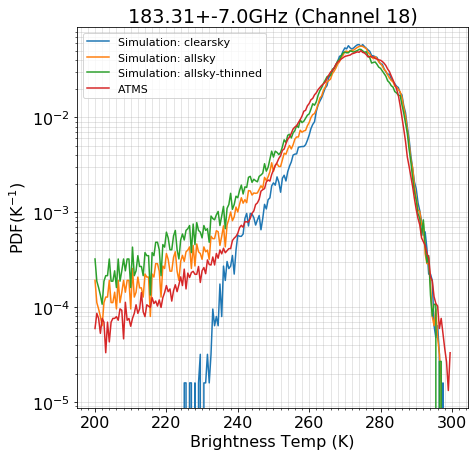

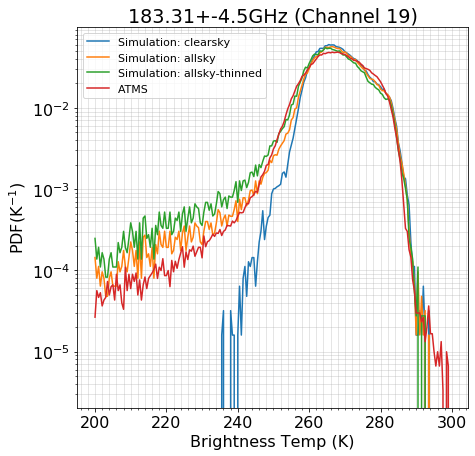

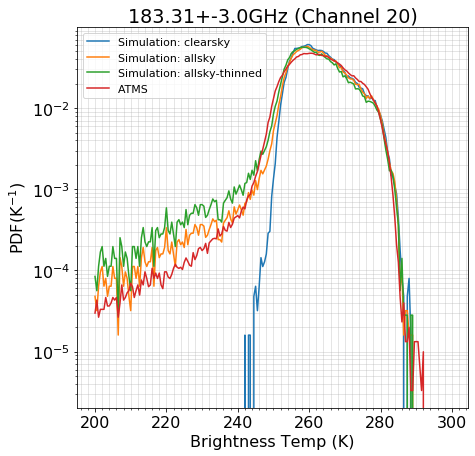

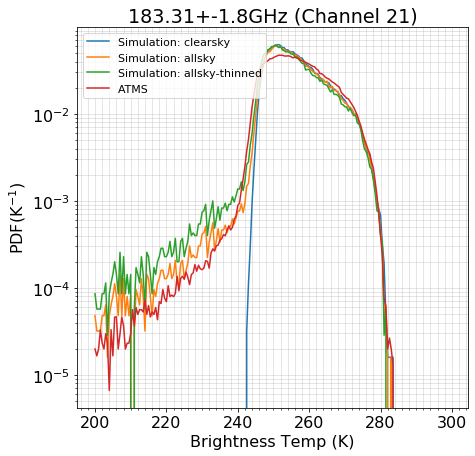

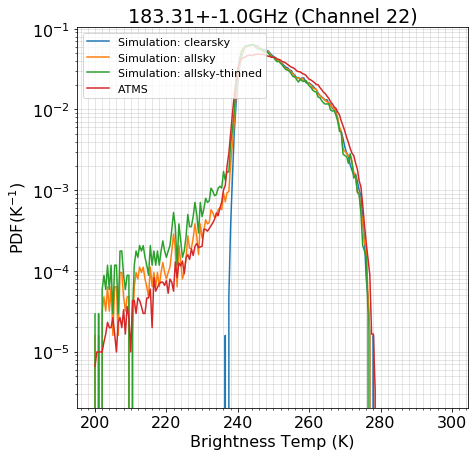

In [12]:
plt.rcParams.update({'font.size': 16})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

channels = ['89.5 GHz (Channel 16)',
            '165.5 GHz (Channel 17)',
            '183.31+-7.0GHz (Channel 18)',
            '183.31+-4.5GHz (Channel 19)',
            '183.31+-3.0GHz (Channel 20)',
            '183.31+-1.8GHz (Channel 21)',
            '183.31+-1.0GHz (Channel 22)']



for i in range(nchannels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    ax.plot( bins[:-1], hist_arts_cs[i])

    ax.plot( bins[:-1], hist_arts_as[i])
    ax.plot( bins[:-1], hist_arts_as_thin[i])

    ax.plot( bins[:-1], hist_atms_day[i])
    ax.set_yscale('log')
    ax.set_xlabel('Brightness Temp (K)', fontsize = 16)  
    ax.set_ylabel('PDF(K$^{-1}$)', fontsize = 16) 
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.grid(which = 'both', alpha = 0.4)
    if i == 0:
        ax.legend(['Simulation: clearsky','Simulation: allsky', 'Simulation: allsky-thinned', 'ATMS'], loc = 'lower left', prop={'size': 11})      
    else:
        ax.legend(['Simulation: clearsky','Simulation: allsky', 'Simulation: allsky-thinned', 'ATMS'], loc = 'upper left', prop={'size': 11})      

    ax.set_title(channels[i])
    plt.show()
    fig.savefig('Figures/ATMS_%s_distribution.png'%(channels_id[i]), bbox_inches='tight')

